In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1 load pickle file with results

In [2]:
df = pd.read_pickle('/home/munoz/sbae_point_analysis/resultsMAATE_ch07/final_results.pickle')
df.columns

Index(['point_id', 'esa_lc20', 'gfc_tc00', 'gfc_loss', 'gfc_year', 'gfc_gain',
       'tmf_main_cl', 'tmf_subtypes', 'tmf_1990', 'tmf_1995', 'tmf_2000',
       'tmf_2005', 'tmf_2010', 'tmf_2015', 'tmf_2020', 'tmf_def_yr',
       'tmf_deg_yr', 'point_idx', 'dates', 'ts', 'images', 'geometry',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'mon_images',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'ts_mean',
       'ts_sd', 'ts_min', 'ts_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_min', 'bs_slope_max'],
      dtype='object')

# 2 K-Means Clustering

[0 1 2 3 4 5 6 7] [36  1 15  2 35  1 18  2]


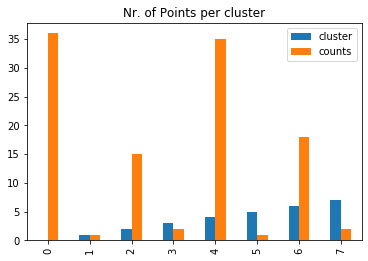

In [3]:
# select columsn thata re used by Kmeans
cols_to_cluster = [
    'mon_images',
    'bfast_magnitude', 'bfast_means', 
    'cusum_confidence', 'cusum_magnitude', 
    'ts_mean', 'ts_sd', 'ts_min', 'ts_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_min', 'bs_slope_max'
]

# Standardize the data
X_std = StandardScaler().fit_transform(df[cols_to_cluster])

# run kmeans
kmeans = KMeans(n_clusters=8, random_state=42).fit(df[cols_to_cluster])
df['Kmeans'] = kmeans.predict(df[cols_to_cluster])

# print number of poitns per clusters
clusters, counts = np.unique(df.Kmeans, return_counts=True)
print(clusters, counts)
pd.DataFrame({'cluster': clusters, 'counts':counts}).plot(kind='bar', title='Nr. of Points per cluster')

# 3 Plot Stats

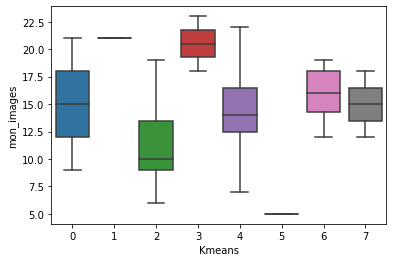

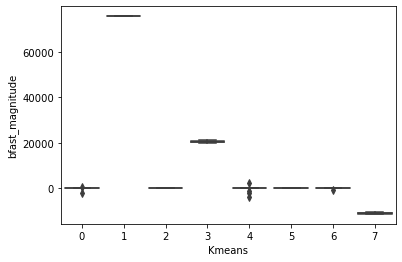

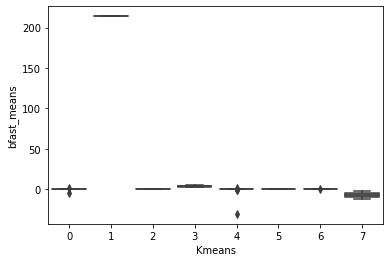

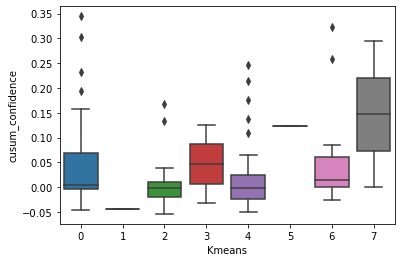

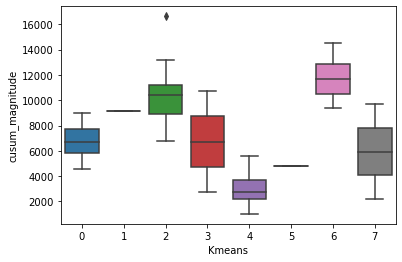

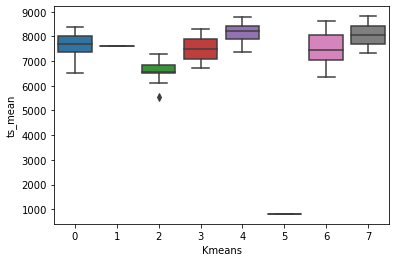

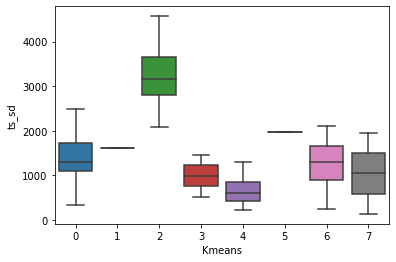

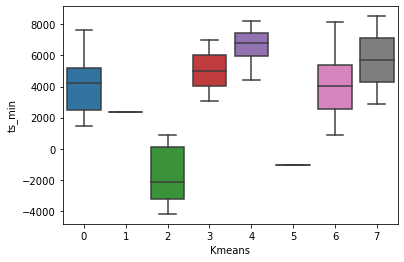

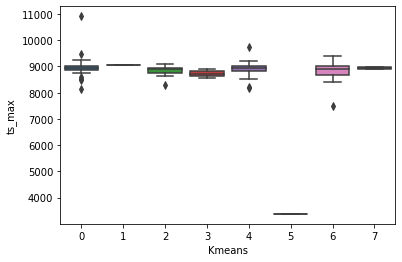

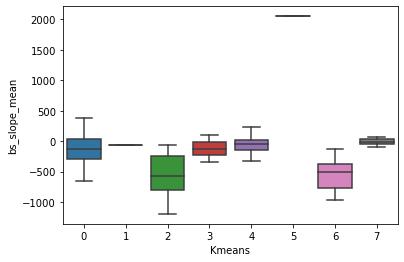

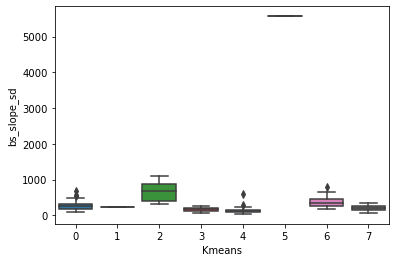

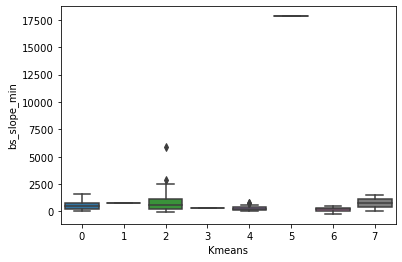

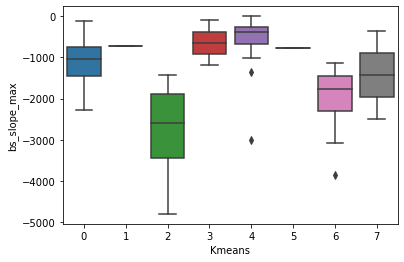

In [4]:
import seaborn as sns

cols_to_plot = [
    'mon_images',
    'bfast_magnitude', 'bfast_means',
    'cusum_confidence', 'cusum_magnitude', 
    'ts_mean', 'ts_sd', 'ts_min', 'ts_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_min', 'bs_slope_max'
]

for i, col in enumerate(cols_to_plot):
    plt.figure(i)
    sns.boxplot(x="Kmeans", y=col, data=df)

# 4 Select subset of samples for each cluster

240 samples have been selected in total


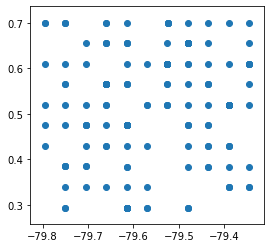

In [5]:
nr_of_samples_per_cluster = 30
subset_df = pd.DataFrame(columns=df.columns)

for cluster in df.Kmeans.unique():
    subset_df = pd.concat([
        subset_df,
        df[df.Kmeans == cluster].sample(nr_of_samples_per_cluster, replace='true')
    ])
    
print(f'{len(subset_df)} samples have been selected in total')
gpd.GeoDataFrame(subset_df, geometry='geometry').plot()

# 5 Convert to CEO file

In [6]:
subset_df['LON'] = gpd.GeoDataFrame(subset_df).geometry.x
subset_df['LAT'] = gpd.GeoDataFrame(subset_df).geometry.y
subset_df['PLOTID'] = gpd.GeoDataFrame(subset_df).point_id

cols = subset_df.columns.tolist()
cols = [e for e in cols if e not in ('LON', 'LAT', 'PLOTID')]
new_cols = ['LON', 'LAT', 'PLOTID'] + cols
subset_df = subset_df[new_cols]
subset_df.to_csv('/home/munoz/sbae_point_analysis/resultsMAATE_ch07/subset_results.csv', index=False)